In [3]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

In [1]:
import torch
#TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
#CUDA_VERSION = torch.__version__.split("+")[-1]
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog,build_detection_test_loader, \
build_detection_train_loader

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'detectron2'

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:24, 7.16MB/s]                              
/home/appuser/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/appuser/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8766, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


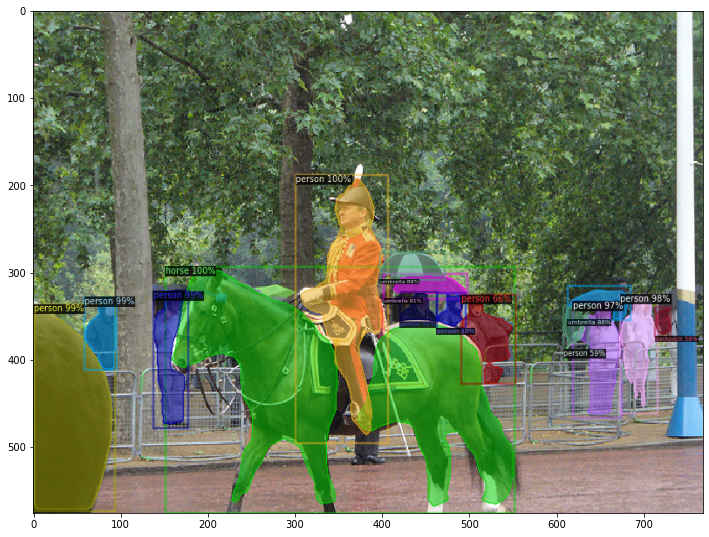

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(1, figsize=(12, 12))
plt.imshow(out.get_image())

# custom data

In [ ]:
data_dir = "/dataset"

In [ ]:
import json
from tqdm import tqdm
label_map = json.load(open("labels.json", "r"))
dic = json.load(open("dic.json", "r"))

In [ ]:
W, H = 1080, 1440
W_new, H_new = 360, 480

def process_or_load_dataset(data_dir, dataset_name = "dataset.pt"):
    try:
        return torch.load(dataset_name)
    except:
        print(f"File not found {dataset_name}")
        paths_filename = {}

        for root, dirs, files in tqdm(os.walk(data_dir), desc="Searching for files"):
            for file in files:
                paths_filename[file] = os.path.join(root, file)

        labels_names = [f for f in paths_filename.keys() if f.endswith(".json")]
        images_names = [f for f in paths_filename.keys() if f.endswith(".jpg")]

        labels_ids = [label.split("/")[-1].strip(".json") for label in labels_names]
        images_ids = [image.split("/")[-1].strip(".jpg") for image in images_names]
        labels_ids_idxs = {label_id: i for i, label_id in enumerate(labels_ids)}
        images_ids_idxs = {image_id: i for i, image_id in enumerate(images_ids)}

        labels_ids_set = set(labels_ids)
        images_ids_set = set(images_ids)
        import csv    
        diff = list(labels_ids_set ^ images_ids_set)
        f = open('errors.csv', 'w', encoding='utf-8', newline='\n')
        wr = csv.writer(f)
        wr.writerows([c.strip() for c in r.strip(', ').split(',')]
                         for r in list(diff))
        f.close()
        print("Missing files written in errors.csv")
        del diff

        pairs = sorted(list(labels_ids_set & images_ids_set)) # matching pairs         

        del labels_ids_set
        del images_ids_set
        labels_idxs = [labels_ids_idxs[pair] for pair in tqdm(pairs, desc="finding pairs for labels")]
        images_idxs = [images_ids_idxs[pair] for pair in tqdm(pairs, desc="finding pairs for images")]
        del labels_ids
        del images_ids
        del labels_ids_idxs
        del images_ids_idxs

        labels_names = [labels_names[idx] for idx in labels_idxs]
        images_names = [images_names[idx] for idx in images_idxs]
        del labels_idxs
        del images_idxs

        # to check the pairs 
        for label_path, image_path in tqdm(zip(labels_names, images_names), desc="checking valid pairs"):
            assert (label_path.split("/")[-1].strip(".json") == image_path.split("/")[-1].strip(".jpg"))

        print("Done validating dataset")

        print("Collecting processed files...")
        labels_paths = [paths_filename[name] for name in tqdm(labels_names)]
        images_paths = [paths_filename[name] for name in tqdm(images_names)]
        print("Done Collection")

        dataset_dicts = []

        for img, label in tqdm(zip(images_paths, labels_paths), desc="Data processing"):
            f = open(os.path.join(data_dir, label), "r")
            json_data = json.load(f)['Learning_Data_Info']
            f.close()        

            if img_type == "R":
                annotations = json_data['Annotations']
                json_id = json_data['Json_Data_ID']
                _, _, cat, cls, img_type, _  = json_id.split("_")
                label = f"{dic[cat]}_{dic[cls]}"
                label = label_map[label]

                objs = []
                record = {}
                record["file_name"] = img
                record["image_id"] = img
                record["height"] = H_new
                record["width"] = W_new

                for ant in annotations:
                    ant_type = ant['Type']
                    if ant_type == "polygon":
                        temp_arr = np.array(ant[ant_type]).reshape(len(ant[ant_type])//2, 2)
                        xmin, ymin = np.min(temp_arr, axis=0)
                        xmax, ymax = np.max(temp_arr, axis=0)

                        if xmin == xmax or ymin == ymax:
                            print(img, "bbox size error (too thin)")
                            continue

                        
                    if ant_type == "bbox":
                        continue
                    
                    for i in range(len(temp_arr)):
                        temp_arr[i][0] = int((temp_arr[i][0] / W) * W_new)
                        temp_arr[i][1] = int((temp_arr[i][1] / H) * H_new)

                    xmin, xmax = xmin/W, xmax/W
                    ymin, ymax = ymin/H, ymax/H

                    xmin, xmax = int(W_new * xmin), int(W_new * xmax)
                    ymin, ymax = int(H_new * ymin), int(H_new * ymax)

                    if xmin == xmax or ymin == ymax:
                        print(img, "bbox size error (too thin)")
                        continue

                    obj = {
                        'bbox':[xmin, ymin, xmax, ymax],
                        'bbox_mode': BoxMode.XYXY_ABS,
                        "category_id": label,
                        "segmentation": [temp_arr.ravel().tolist()], 
                        "iscrowd" : 0
                    }
                    objs.append(obj)

                if len(objs) == 0:
                    continue
                record['annotations'] = objs
                dataset_dicts.append(record)
        print("클래스, 인덱스 맵핑", label_map)
        torch.save(dataset_dicts, f"{dataset_name}")
        print(f"dataset saved to {dataset_name}")
        return dataset_dicts

In [ ]:
dataset_dicts = process_or_load_dataset("/dataset", "dataset.pt")

In [ ]:
dataset_dicts = process_or_load_dataset(DATASET_FOLDER, DATASET_NAME_TO_SAVE OR DATASET_NAME_TO_LOAD)

In [16]:
n = len(dataset_dicts)
train, val, test = dataset_dicts[:int(0.8 * n)], dataset_dicts[int(0.8 * n):int(0.9 * n)], dataset_dicts[int(0.9 * n):]

In [17]:
def get_dataset(d):
    if d == "train":
        return train
    elif d == "val":
        return val
    elif d == "test":
        return test

In [21]:
DatasetCatalog.clear()

In [22]:
datasets = [train, val, test]
thing_classes = []

for i in range(1, len(label_map)+1):
    thing_classes.append(label_map[i])

for d, dataset in zip(["train", "val", "test"], datasets):
    DatasetCatalog.register("e8ight_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("e8ight_" + d).thing_classes=thing_classes
e8ight_metadata = MetadataCatalog.get("e8ight_train")

# Train

In [72]:
%%writefile train_net_mask.py
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
import copy
def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    image /= 255.0
    transform_list = [T.Resize((H_new, W_new))]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class E8ightTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, 
                                           dataset_name, 
                                           mapper =custom_mapper)
    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder="output/maskrcnn"):
        assert (output_folder != None)
        return COCOEvaluator(dataset_name, 
                             max_dets_per_image = 300, 
                             output_dir=output_folder)
    @classmethod
    def build_optimizer(cls, cfg, model):
        norm_module_types = (
        torch.nn.BatchNorm1d,
        torch.nn.BatchNorm2d,
        torch.nn.BatchNorm3d,
        torch.nn.SyncBatchNorm,
        # NaiveSyncBatchNorm inherits from BatchNorm2d
        torch.nn.GroupNorm,
        torch.nn.InstanceNorm1d,
        torch.nn.InstanceNorm2d,
        torch.nn.InstanceNorm3d,
        torch.nn.LayerNorm,
        torch.nn.LocalResponseNorm,
    )
        params= []
        memo = set()
        for module in model.modules():
            for key, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)
                lr = cfg.SOLVER.BASE_LR
                weight_decay = cfg.SOLVER.WEIGHT_DECAY
                if isinstance(module, norm_module_types):
                    weight_decay = cfg.SOLVER.WEIGHT_DECAY_NORM
                elif key == "bias":
                    # NOTE: unlike Detectron v1, we now default BIAS_LR_FACTOR to 1.0
                    # and WEIGHT_DECAY_BIAS to WEIGHT_DECAY so that bias optimizer
                    # hyperparameters are by default exactly the same as for regular
                    # weights.
                    lr = cfg.SOLVER.BASE_LR * cfg.SOLVER.BIAS_LR_FACTOR
                    weight_decay = cfg.SOLVER.WEIGHT_DECAY_BIAS
                params += [{"params": [value], "lr": lr, "weight_decay": weight_decay}]
        optimizer = torch.optim.Adam(params, cfg.SOLVER.BASE_LR)
        return optimizer
def build_cfg(save_every,  base_lr):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
   
    cfg.DATASETS.TRAIN = ("e8ight_train",)
    cfg.DATASETS.TEST = ("e8ight_val", )
    cfg.DATALOADER.NUM_WORKERS = 4
    
    
    
    cfg.TEST.EVAL_PERIOD = save_every # No. of iterations after which the Validation Set is evaluated.

    # 0 for no resize
    cfg.INPUT.MIN_SIZE_TEST = 0
    cfg.INPUT.MAX_SIZE_TEST = 0
    # Change input format
    cfg.INPUT.FORMAT = "RGB"

    # ---------------------------------------------------------------------------- #
    # Anchor generator options
    # ---------------------------------------------------------------------------- #
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512]]
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 1.5, 2.0]]
    # Anchor angles.
    # list[list[float]], the angle in degrees, for each input feature map.
    # ANGLES[i] specifies the list of angles for IN_FEATURES[i].
    # Loss type, choose from `cross_entropy`, `hard_pixel_mining`.
    cfg.MODEL.SEM_SEG_HEAD.LOSS_TYPE = "cross_entropy"
    # DeepLab settings
    cfg.MODEL.SEM_SEG_HEAD.PROJECT_FEATURES = ["res2"]
    cfg.MODEL.SEM_SEG_HEAD.PROJECT_CHANNELS = [48]
    cfg.MODEL.SEM_SEG_HEAD.ASPP_CHANNELS = 256
    cfg.MODEL.SEM_SEG_HEAD.ASPP_DILATIONS = [6, 12, 18]
    cfg.MODEL.SEM_SEG_HEAD.ASPP_DROPOUT = 0.1
    cfg.MODEL.SEM_SEG_HEAD.USE_DEPTHWISE_SEPARABLE_CONV = True

    cfg.SOLVER.WARMUP_ITERS = 200
    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.MAX_ITER = 40000
    cfg.SOLVER.STEPS = [i for i in range(cfg.SOLVER.WARMUP_ITERS, cfg.SOLVER.MAX_ITER, 500)]
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.GAMMA = 0.95
    cfg.SOLVER.MOMENTUM = 0.9
    cfg.SOLVER.NESTEROV = False
    cfg.SOLVER.WEIGHT_DECAY_BIAS = 0.9 
    cfg.OUTPUT_DIR = "output/maskrcnn"


    # Save a checkpoint after every this number of iterations
    cfg.SOLVER.CHECKPOINT_PERIOD = save_every
    return cfg

def save_cfg(save_every, base_lr):
    cfg = build_cfg(save_every = save_every,  base_lr = base_lr)
    cfg_file = yaml.safe_load(cfg.dump())
    os.makedirs('configs', exist_ok=True)
    with open('configs/mask.yaml', 'w') as f:
        yaml.dump(cfg_file, f)
    return cfg


def setup(args):
    cfg = save_cfg(save_every=500, base_lr=0.0001)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg


def main(args):
    cfg = setup(args)

    if args.eval_only:
        model = E8ightTrainer.build_model(cfg)
        DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
            cfg.MODEL.WEIGHTS, resume=args.resume
        )
        res = E8ightTrainer.test(cfg, model)
        return res

    trainer = E8ightTrainer(cfg)
    trainer.resume_or_load(resume=args.resume)
    return trainer.train()


if __name__ == "__main__":
    args = default_argument_parser().parse_args()
    print("Command Line Args:", args)
    launch(
        main,
        args.num_gpus,
        num_machines=args.num_machines,
        machine_rank=args.machine_rank,
        dist_url=args.dist_url,
        args=(args,),
    )

[10/26 18:09:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/26 18:09:10 d2.data.build]: Removed 0 images with no usable annotations. 732 images left.
[10/26 18:09:11 d2.data.build]: Using training sampler TrainingSampler
[10/26 18:09:11 d2.data.common]: Serializing 732 elements to byte tensors and concatenating them all ...
[10/26 18:09:11 d2.data.common]: Serialized dataset takes 0.88 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (23, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (23,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (88, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (88,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (22, 256, 1, 

[10/26 18:09:11 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[10/26 18:09:14 d2.utils.events]:  eta: 0:01:33  iter: 19  total_loss: 3.858  loss_cls: 3.014  loss_box_reg: 0.0472  loss_mask: 0.695  loss_rpn_cls: 0.09186  loss_rpn_loc: 0.006412  time: 0.1599  data_time: 0.0146  lr: 8.1588e-06  max_mem: 2198M
[10/26 18:09:18 d2.utils.events]:  eta: 0:01:31  iter: 39  total_loss: 3.402  loss_cls: 2.569  loss_box_reg: 0.03288  loss_mask: 0.6917  loss_rpn_cls: 0.1065  loss_rpn_loc: 0.006475  time: 0.1641  data_time: 0.0030  lr: 1.6484e-05  max_mem: 2198M
[10/26 18:09:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/26 18:09:19 d2.data.common]: Serializing 91 elements to byte tensors and concatenating them all ...
[10/26 18:09:19 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [10/26 18:09:19 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[10/26 18

[10/26 18:10:16 d2.utils.events]:  eta: 0:00:43  iter: 359  total_loss: 0.8814  loss_cls: 0.1874  loss_box_reg: 0.1751  loss_mask: 0.5379  loss_rpn_cls: 0.002782  loss_rpn_loc: 0.003317  time: 0.1796  data_time: 0.0029  lr: 0.00014968  max_mem: 2198M
[10/26 18:10:20 d2.utils.events]:  eta: 0:00:40  iter: 379  total_loss: 0.9448  loss_cls: 0.1874  loss_box_reg: 0.1825  loss_mask: 0.5901  loss_rpn_cls: 0.001409  loss_rpn_loc: 0.002733  time: 0.1803  data_time: 0.0029  lr: 0.00015801  max_mem: 2198M
[10/26 18:10:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/26 18:10:24 d2.data.common]: Serializing 91 elements to byte tensors and concatenating them all ...
[10/26 18:10:24 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [10/26 18:10:24 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


In [ ]:
!python3 train_net_mask.py --num-gpus 1

In [73]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
val_dataset = "e8ight_val"
evaluator = COCOEvaluator(val_dataset, cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_dataset)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [10/26 18:13:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/26 18:13:49 d2.evaluation.coco_evaluation]: Trying to convert 'e8ight_val' to COCO format ...
[10/26 18:13:49 d2.data.datasets.coco]: Converting annotations of dataset 'e8ight_val' to COCO format ...)
[10/26 18:13:49 d2.data.datasets.coco]: Converting dataset dicts into COCO format


ValueError: Cannot create a polygon from 4 coordinates.

# Inf eval

In [86]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold

predictor = DefaultPredictor(cfg)

In [ ]:
test_dicts = dataset_dicts[:len(dataset_dicts)//100] 

In [2]:
from detectron2.utils.visualizer import ColorMode
import random
import cv2
import matplotlib.pyplot as plt
e8ight_metadata = MetadataCatalog.get("e8ight_test")
for d in random.sample(test_dicts, 1):    
    filename = d['file_name']
    im = cv2.resize(plt.imread(filename), (W_new, H_new), interpolation=cv2.INTER_NEAREST)
    annotations = d['annotations']
    
    
        
    
    print(d["file_name"].replace("raw", "label").replace("jpg", "json"))
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    #print(outputs)
    v = Visualizer(im,
                   metadata=e8ight_metadata, 
                
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    out = out.overlay_instances(
        labels=[ant['category_id'] for ant in annotations],
        boxes=[ant['bbox'] for ant in annotations],
        masks=[ant['segmentation'] for ant in annotations]
    )
    plt.figure(1, figsize=(24, 24))
    plt.imshow(out.get_image())

ModuleNotFoundError: No module named 'detectron2'

In [88]:
print(outputs["instances"].pred_boxes)

Boxes(tensor([[  0.0000,   0.0000,  67.8896,  47.0996],
        [  0.0000,   0.0000, 136.3140,  51.7671],
        [  0.0000,   0.0000,  93.4629,  57.6570],
        [  0.0000,   7.6511,  52.0269,  69.5430],
        [  0.0000,   0.0000, 136.0076,  53.0354],
        [  0.0000,   0.0000,  79.0758,  38.6065],
        [  0.0000,   0.0000,  44.6250,  66.7517],
        [  0.0000,   2.6367,  78.8315,  88.6642],
        [  9.5251,   0.0000,  68.1191,  65.9550]], device='cuda:0'))


In [90]:
print(outputs["instances"].pred_classes)

tensor([8, 8, 6, 8, 4, 4, 6, 8, 4], device='cuda:0')
